# BatchNorm

ps：

pip install d2l

pip install matplotlib==3.0.0


训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。在本节中，我们将介绍批量 规范化(batch normalization)[Ioffe & Szegedy, 2015]，这是一种流行且有效的技术，可持续加速深层网络 的收敛速度。

首先，数据预处理的方式通常会对最终结果产生巨大影响。回想一下我们应用多层感知机来预测房价的例子 (4.10节)。使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。

第二，对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量(例如，多层感知机中的仿射变换输出)可能具有更广的变化范围:不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测。批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。直观地说，我们可能会猜想，如果一个层的可变值是另一层的100倍，这可能需要 对学习率进行补偿调整。

第三，更深层的网络很复杂，容易过拟合。这意味着正则化变得更加重要。

批量规范化应用于单个可选层(也可以应用到所有层)，其原理如下:在每次训练迭代中，我们首先规范化输 入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。接下来，我们应用比例系数和比 例偏移。正是由于这个基于批量统计的标准化，才有了批量规范化的名称。

从形式上来说，用$\pmb x ∈ B$表示一个来自小批量B的输入，批量规范化$B_N$根据以下表达式转换$\pmb x$:

$$B_N(\pmb x) = \gamma \frac{\pmb X - \pmb {\hat\mu_B}}{\pmb{\hat  \sigma_B}} + \pmb \beta$$


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt

## Artifical BatchNorm Code

In [2]:
# def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum): 
#   # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
#   if not torch.is_grad_enabled():
#   # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
#     X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps) 
#   else:
#     assert len(X.shape) in (2, 4) 
#     if len(X.shape) == 2:
#     # 使用全连接层的情况，计算特征维上的均值和方差 
#       mean = X.mean(dim=0)
#       var = ((X - mean) ** 2).mean(dim=0)
#     else:
#       # 使用二维卷积层的情况，计算通道维上(axis=1)的均值和方差。
#       # 这里我们需要保持X的形状以便后面可以做广播运算
#       mean = X.mean(dim=(0, 2, 3), keepdim=True)
#       var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
#     # 训练模式下，用当前的均值和方差做标准化
#     X_hat = (X - mean) / torch.sqrt(var + eps)
#     # 更新移动平均的均值和方差
#     moving_mean = momentum * moving_mean + (1.0 - momentum) * mean 
#     moving_var = momentum * moving_var + (1.0 - momentum) * var 
#     # 缩放和移位
#   Y = gamma * X_hat + beta 
#   return Y, moving_mean.data, moving_var.data

In [3]:
# class BatchNorm(nn.Module):
#   # num_features:完全连接层的输出数量或卷积层的输出通道数。 
#   # num_dims:2表示完全连接层，4表示卷积层
#   def __init__(self, num_features, num_dims):
#     super().__init__() 
#     if num_dims == 2:
#       shape = (1, num_features) 
#     else:
#       shape = (1, num_features, 1, 1)
#     # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0 
#     self.gamma = nn.Parameter(torch.ones(shape)) 
#     self.beta = nn.Parameter(torch.zeros(shape)) 
#     # 非模型参数的变量初始化为0和1
#     self.moving_mean = torch.zeros(shape) 
#     self.moving_var = torch.ones(shape)

#   def forward(self, X):
#     # 如果X不在内存上，将moving_mean和moving_var # 复制到X所在显存上
#     if self.moving_mean.device != X.device:
#         self.moving_mean = self.moving_mean.to(X.device)
#     self.moving_var = self.moving_var.to(X.device) # 保存更新过的moving_mean和moving_var
#     Y, self.moving_mean, self.moving_var = batch_norm(
#              X, self.gamma, self.beta, self.moving_mean,
#               self.moving_var, eps=1e-5, momentum=0.9) 
#     return Y

## Test on LeNet

In [4]:
# 1. 加载数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
# 2. net
class Reshape(torch.nn.Module):

  def forward(self, x):
    return x.reshape(-1, 1, 28, 28)

net = nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    nn.BatchNorm1d(120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(),
    nn.Linear(84, 10),
)

In [9]:
# 3. 初始化weight

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

# 4. 定义loss

l = nn.CrossEntropyLoss()

# 5. 定义优化器

o = torch.optim.SGD(net.parameters(), lr=1)

In [10]:
def acc(X,y,net):
  p_predict = net(X)
  y_predict = torch.argmax(p_predict,axis=1)
  output = y_predict - y
  right_pre = len(output[output==0])
  right_accu = right_pre/len(output)
  return right_accu

def eval_accu(net=None, dataset=None, cuda=False):
  accu = 0
  batch = 0
  net.eval()

  for X,y in dataset:
    if cuda:
      net.cuda()
      X,y = X.cuda(),y.cuda()
    accu += acc(X, y, net)
    batch += 1
  avg_acc = accu/batch
  return avg_acc

def train_net(net=None, epochs=10, loss = None, optimizer=None, 
              train_iter=None, test_iter=None, cuda=False):
  train_accu_history = []
  test_accu_history = []
  train_loss = []

  for epoch in range(epochs):

    net.train()
    for X,y in train_iter:
      if cuda:
        net.cuda()
        X,y = X.cuda(),y.cuda()
      l = loss(net(X), y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()

    net.eval() 
    l = loss(net(X), y)
    train_loss.append(l.cpu().detach())
    

    train_avg_acc = eval_accu(net, train_iter, cuda)
    test_avg_acc = eval_accu(net, test_iter, cuda)
    train_accu_history.append(train_avg_acc)
    test_accu_history.append(test_avg_acc)

    print(f'epoch {epoch + 1}, loss {l:f}, train_accu {train_avg_acc:f}, test_accu {test_avg_acc:f}')
  
  x_label_value = [str(i) for i in range(1,epochs+1)]
  plt.plot(x_label_value, train_accu_history, label='train_accu', color='g', linestyle='dashed')
  plt.plot(x_label_value, test_accu_history, label='test_accu', color='r', linestyle='dashed')
  plt.plot(x_label_value, train_loss, label='train_loss', color='b')
  plt.xlabel('epoch')
  plt.ylim(0.1,2)
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 0.456225, train_accu 0.745717, test_accu 0.745634
epoch 2, loss 0.296749, train_accu 0.795833, test_accu 0.796055
epoch 3, loss 0.249613, train_accu 0.842753, test_accu 0.842642
epoch 4, loss 0.217552, train_accu 0.840309, test_accu 0.840226
epoch 5, loss 0.226981, train_accu 0.872933, test_accu 0.872850
epoch 6, loss 0.215108, train_accu 0.858732, test_accu 0.858843
epoch 7, loss 0.504898, train_accu 0.817830, test_accu 0.818052
epoch 8, loss 0.102806, train_accu 0.903923, test_accu 0.903951
epoch 9, loss 0.506696, train_accu 0.795107, test_accu 0.794969
epoch 10, loss 0.166105, train_accu 0.857441, test_accu 0.857469


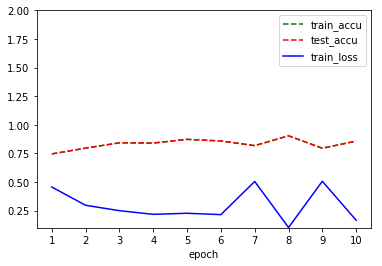

CPU times: user 32.7 s, sys: 10.3 s, total: 43 s
Wall time: 2min 48s


In [11]:
%%time
train_net(net=net, epochs=10, loss = l, optimizer=o, 
          train_iter=train_iter, test_iter=train_iter, cuda=True)